# Exponential Moving Average Demo

In this notebook, we will demonstrate how an exponential moving average is calculated. We will plot exponential moving average (EMA) lines of different periods and alpha decay ratios to show how changing these values changes the characteristics of the EMA.

[Moving Averages on Wikipedia](https://en.wikipedia.org/wiki/Moving_average)

## Exponential Moving Average (EMA) Approximation
The non-recursive approximation equation for exponential moving average is:

EMA_today = numerator / denominator

numerator   = p1 + (1-a) * p2 + (1-a)<sup>2</sup> * p3 + (1-a)<sup>3</sup> * p4 + (1-a)<sup>4</sup> * p5 + ...

denominator = 1  +  (1-a)  +  (1-a)<sup>2</sup>  +  (1-a)<sup>3</sup>  +  (1-a)<sup>4</sup>  +  ...

Where p1 is the value TODAY, p2 is the value YESTERDAY, and so on.

And a is the rate of decay (a constant between 0 and 1).

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Exploring alpha decay

What does alpha decay in the first 20 coefficents really look like for a=0.1 and a=0.5?

bottom = 1 + (1-a) + (1-a)^2 + (1-a)^3 + ...

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y: 0.001953125


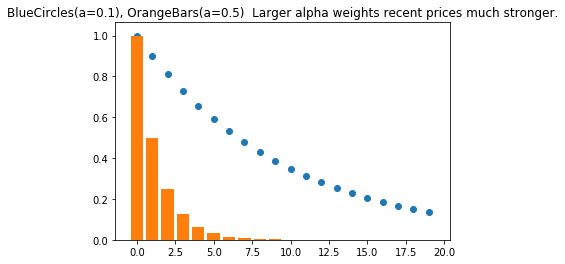

In [2]:
qq = np.arange(20)

print(qq)
alpha = 0.5
def getCof(data, alpha, index):
    exponent = data[index]
    term = (1-alpha)**exponent
    return term

def getCofList(data, alpha):
    cofs = []
    i = 0
    while i < len(data):
        cof = getCof(data, alpha, i)
        cofs.append(cof)
        i = i + 1
    return cofs
    
y = getCof(qq, alpha, 9)
print("y:", y)
cof_05 = getCofList(qq, 0.5)
#print("cof_05:", cof_05)

cof_01 = getCofList(qq, 0.1)

plt.figure(3)
plt.scatter(qq, cof_01)
plt.bar(qq, cof_05)
title = "BlueCircles(a=0.1), OrangeBars(a=0.5)  Larger alpha weights recent prices much stronger."
plt.title(title)
plt.show()


## Relationship Between alpha and period
For large alpha values, only a small period is needed since the oldest values will have a very small coefficient.

For small alpha values, a larger period is needed since more values will have a significantly large coefficient.

A commonly used equation to relate alpha to period is:

alpha = 2 / ( period + 1 )

Or written another way:

period = ( 2 / alpha ) - 1

This equation allows us to easily compare the exponential moving average to a simple moving average because they can be both written with only the period number.

In [3]:
bigData = [1, 0, 2, 3, 8, 7, 9, 6, 7, 5, 9, 4, 6, 7, 7, 6, 6, 8, 9, 4, 
           1, 0, 2, 3, 8, 7, 9, 6, 7, 5, 9, 4, 6, 7, 7, 6, 6, 8, 9, 4,
           4, 5, 5, 6, 7, 8, 9, 8, 9, 10, 11, 12, 10, 11, 12, 9, 4, 3]
x = getTimeline(len(bigData))
print("A Larger alpha responds faster to price, and is less smooth")
print("given the same number of terms.")
plt.figure(1)
plt.plot(x, bigData)
ema_data_01_15 = getEMAdataset(bigData, 0.1, 15)
plt.plot(x, ema_data_01_15)
ema_data_05_15 = getEMAdataset(bigData, 0.5, 15)
plt.plot(x, ema_data_05_15)
title = "Price:Blue, EMA(a=0.5):Green, EMA(a=0.1):Orange"
plt.title(title)
plt.show()

NameError: name 'getTimeline' is not defined

In [ ]:
testData = [1, 0, 2, 3, 8]

def getTimeline(end):
    x = np.arange(end)
    return x

def getBottom(a, number_of_terms):
    # bottom = 1 + (1-a) + (1-a)^2 + (1-a)^3 + ...
    i = 0
    total = 0
    while i < number_of_terms:
        term = (1-a)**i
        total = total + term
        i = i + 1
    return total

#test_bottom = getBottom(0.5, 3)
#print("test_bottom:", test_bottom)

def getTop(price_data, price_data_index, a, number_of_terms):
    # top = p1 + (1-a)*p2 + (1-a)^2*p3 + (1-a)^3*p4 + ...
    i = 0
    total = 0
    while i < number_of_terms:
        #print("term number:", i)
        price = price_data[price_data_index - i]
        #print("price:", price)
        cof = (1-a)**i
        #print("cof:", cof)
        term = price * cof
        #print("term:", term)
        #print(" ")
        total = total + term
        i = i + 1
    return total

#test_top = getTop(testData,2, 0.5, 3)
#print("test_top:", test_top)

def getEMA(price_data, price_data_index, alpha, number_of_terms):
    #print("index:",price_data_index,"alpha:",alpha,"number_of_terms:",number_of_terms)
    if (number_of_terms - price_data_index) > 1:
        #print("too many terms for this index")
        return 0
    else:
        top = getTop(price_data, price_data_index, alpha, number_of_terms)
        bottom = getBottom(alpha, number_of_terms)
        #print("top:", top)
        #print("bottom:", bottom)
        EMA = top / bottom
        return EMA

test_EMA = getEMA(testData, 2, 0.5, 2)
print("correct answer: top=2, bottom=1.5, EMA=1.333")
print("test_EMA:", test_EMA)
print(" ")

test_EMA = getEMA(testData, 2, 0.5, 3)
print("correct answer: top=2.25, bottom=1.75, EMA=1.286")
print("test_EMA:", test_EMA)
print(" ")

test_EMA = getEMA(testData, 2, 0.5, 4)
print("correct answer: EMA=0 because #terms(4) - index(2) > 1")

print("test_EMA:", test_EMA)
print(" ")


def getEMAdataset(price_data, alpha, number_of_terms):
    ema_data = []
    i = 0
    while i < len(price_data):
        datum = getEMA(price_data, i, alpha, number_of_terms)
        ema_data.append(datum)
        i = i + 1
    return ema_data



In [ ]:
plt.figure(2)
print("A larger number of terms is smoother than a small number with same alpha.")
plt.plot(x, bigData)
ema_data_01_10 = getEMAdataset(bigData, 0.1, 10)
plt.plot(x, ema_data_01_10)
ema_data_01_30 = getEMAdataset(bigData, 0.1, 30)
plt.plot(x, ema_data_01_30)
title = "Price:Blue, EMA(30):Green, EMA(10):Orange"
plt.title(title)
plt.show()